# Missing Data Problem
Equinor collects a lot of data from the windmills and ends up with datasets with a lot of missing data. The current dataset is a real example of one of these and a problem is analysing such a dataset. This document will try to find look after patterns in the missing data. Perhaps some tags and turbines can be separated, and perhaps some tags affects other tags in the dataset?

## Loading the dataset to the notebook

In [0]:
!curl -O https://eqhck20storage.blob.core.windows.net/missing-data/missing_data_task.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1729M  100 1729M    0     0  5610k      0  0:05:15  0:05:15 --:--:-- 4174k


In [0]:
import pandas as pd
data = pd.read_csv('missing_data_task.csv', nrows=1000, index_col=[0], parse_dates=[0])

### Splitting up the data by turbine

In [0]:
turbines = {}
for key in data.keys():
  turbine = key.split('-')[0]
  if turbine in turbines:
    continue

  turbines[turbine] = pd.DataFrame()

  columns = sorted([col.split('-')[1] for col in filter(lambda s: key[:3] in s, data.columns)])
  for col in columns:
    turbines[turbine][col] = data[f'{turbine}-{col}']
  turbines[key[:3]]["timestamp"] = turbines[key[:3]].index
T = turbines

## Results
Visualizing the column attributes for two turbines to get a good overview of the available data.

In [0]:
import plotly.graph_objects as go


def visualizeTurbine(turbine):
  fig = go.Figure()

  t = turbines[turbine]
  for column in t.columns:
    fig.add_trace(go.Scatter(x=t["timestamp"], y=t[column], name=column))

  fig.show()

visualizeTurbine("T01")
visualizeTurbine("T02")

## Nullity Matrix
The msno.matrix nullity matrix is a data-dense display which lets you quickly visually pick out patterns in data completion. The sparkline at right summarizes the general shape of the turbine-data completeness and points out the rows with the maximum and minimum nullity in the dataset for turbine 04. The purpose of drawing the matrix for all the columns is to see what values are missing, and to get a general overview of the missing data.



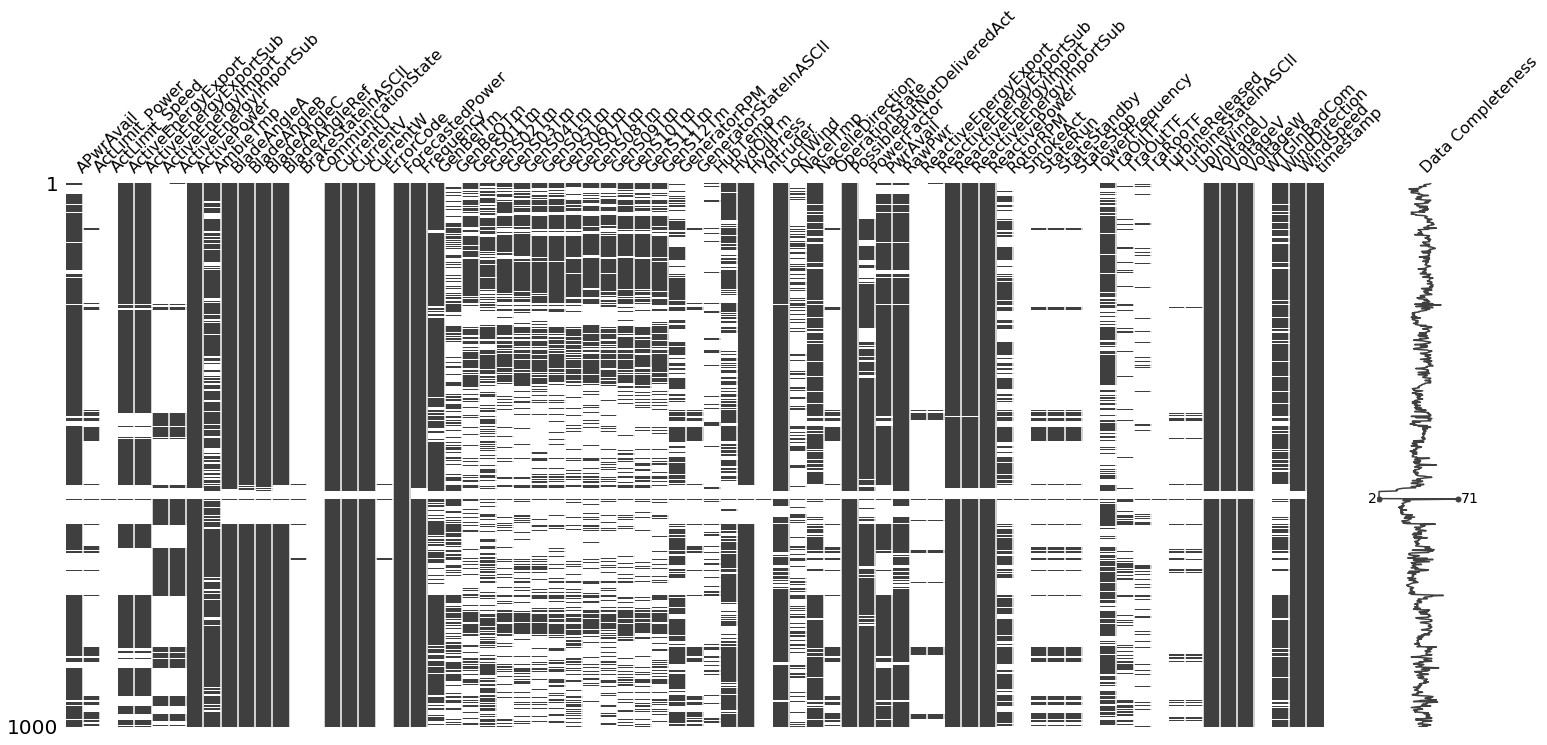

In [0]:
import missingno as msno
msno.matrix(turbines["T04"], labels=True)

## Bar chart | Number of non-null values per attribute
The bar chart gives a much more simpler overview of the data. Let us look at turbine 04 again.

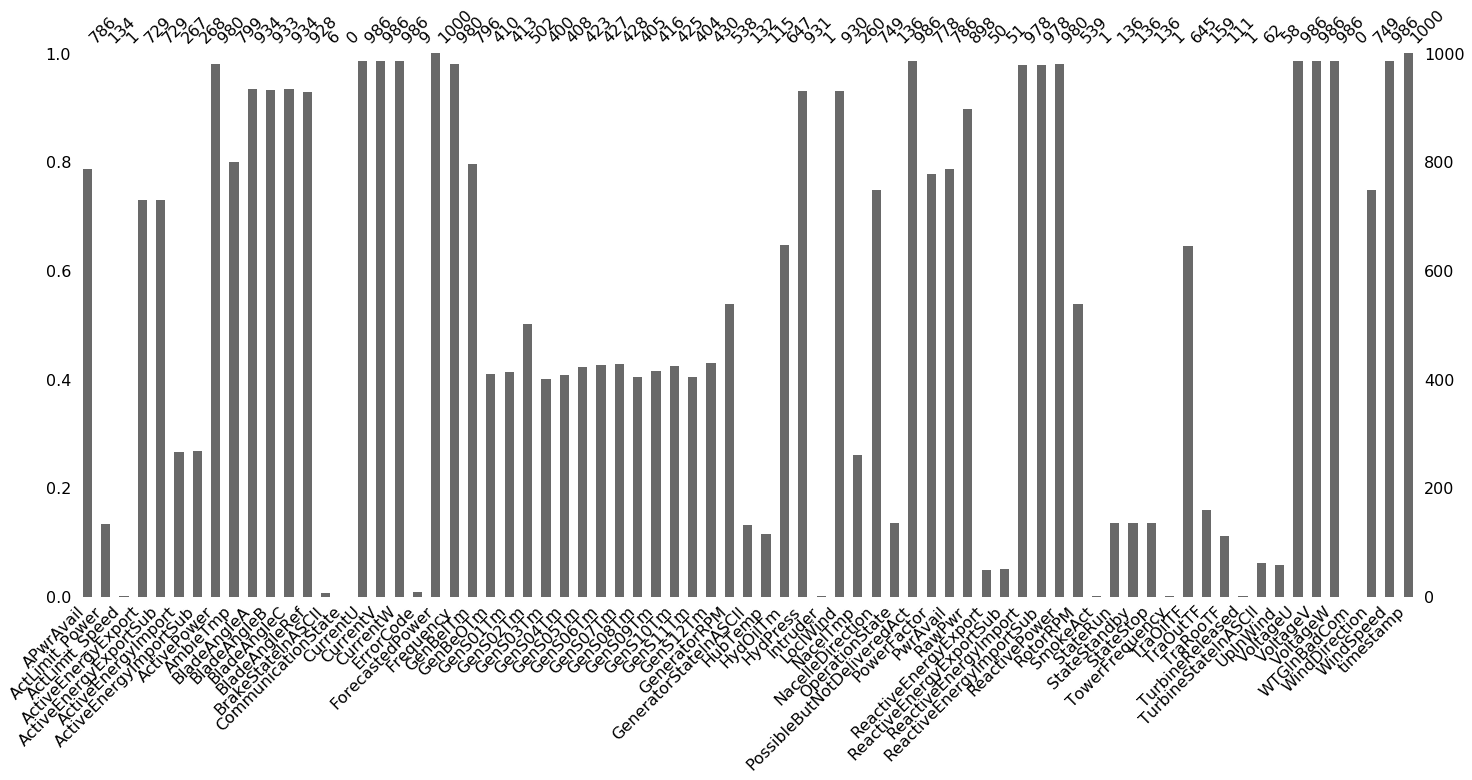

In [0]:
msno.bar(turbines["T04"], labels=True)

## Heatmap

The heatmap is probably the most important visualization for this dataset, because it  measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another. Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does).

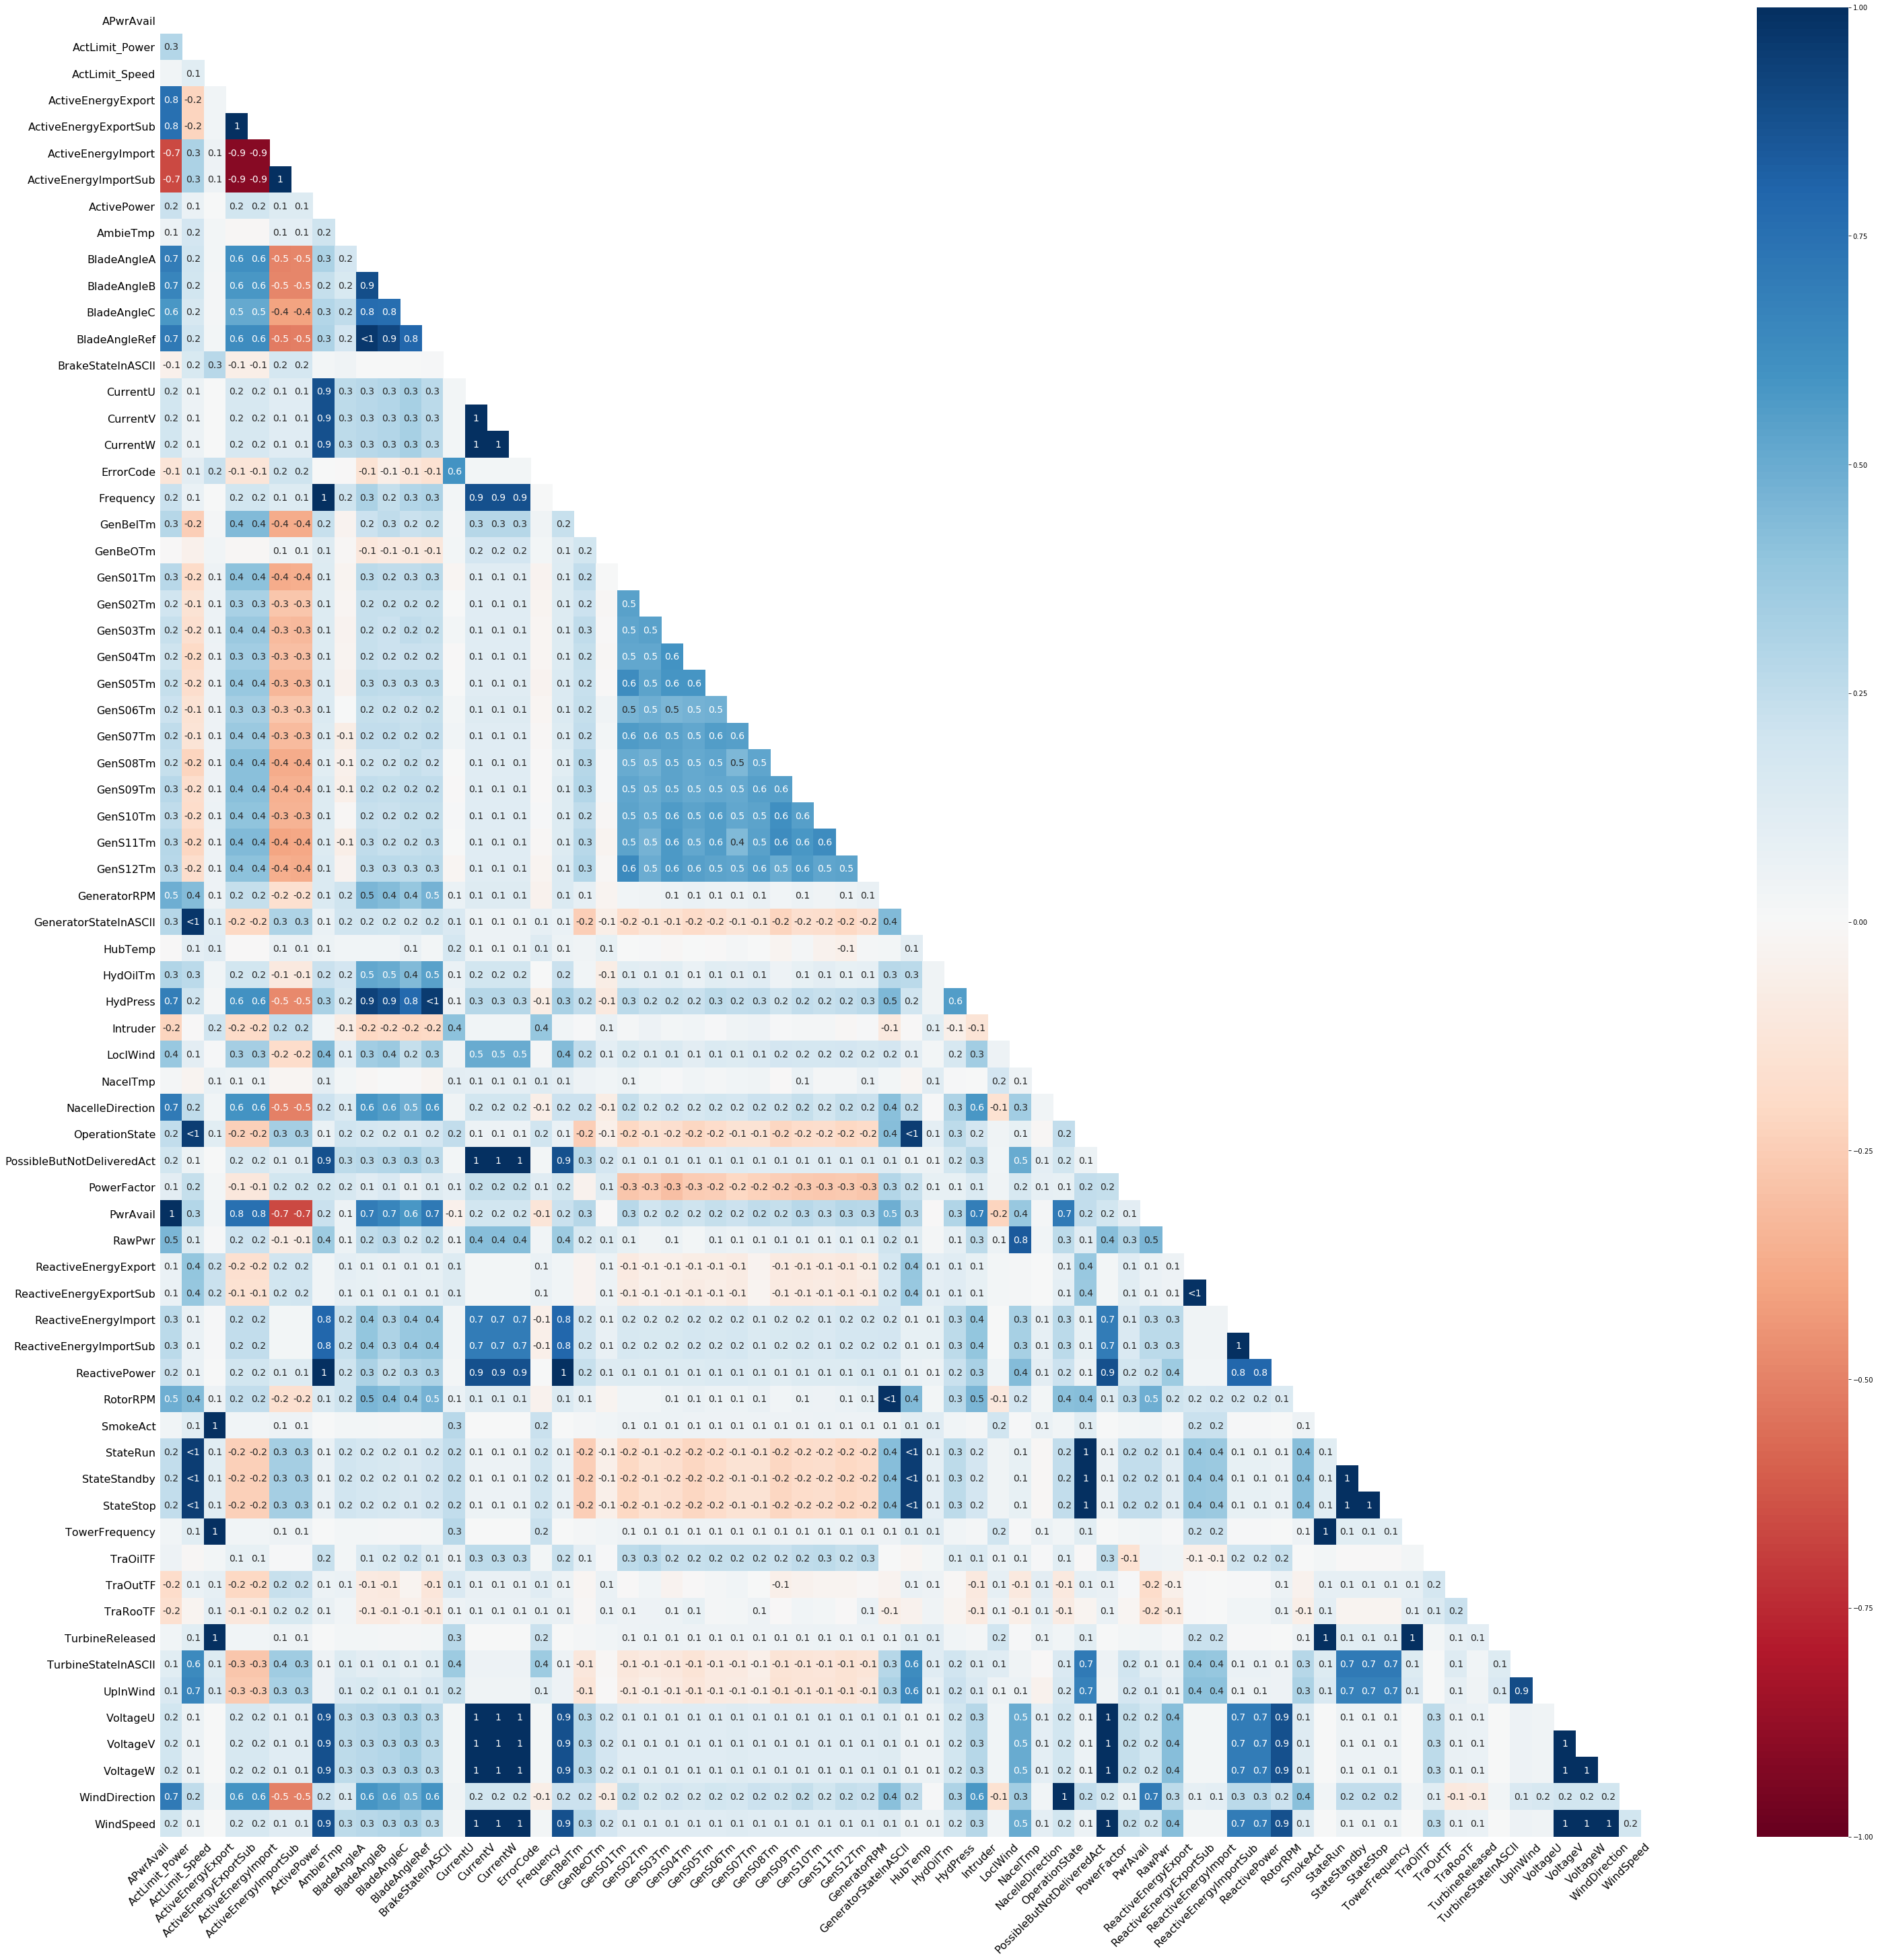

In [0]:
msno.heatmap(turbines["T01"], figsize=((50,50)))


## Dendrogram
The dendrogram allows us to more fully correlate variable completion, revealing trends deeper than the pairwise ones visible in the correlation heatmap. The dendrogram uses a hierarchical clustering algorithm to bin variables against one another by their nullity correlation (measured in terms of binary distance). Below we have drawn out a dendrogram for the first turbine in the dataset.

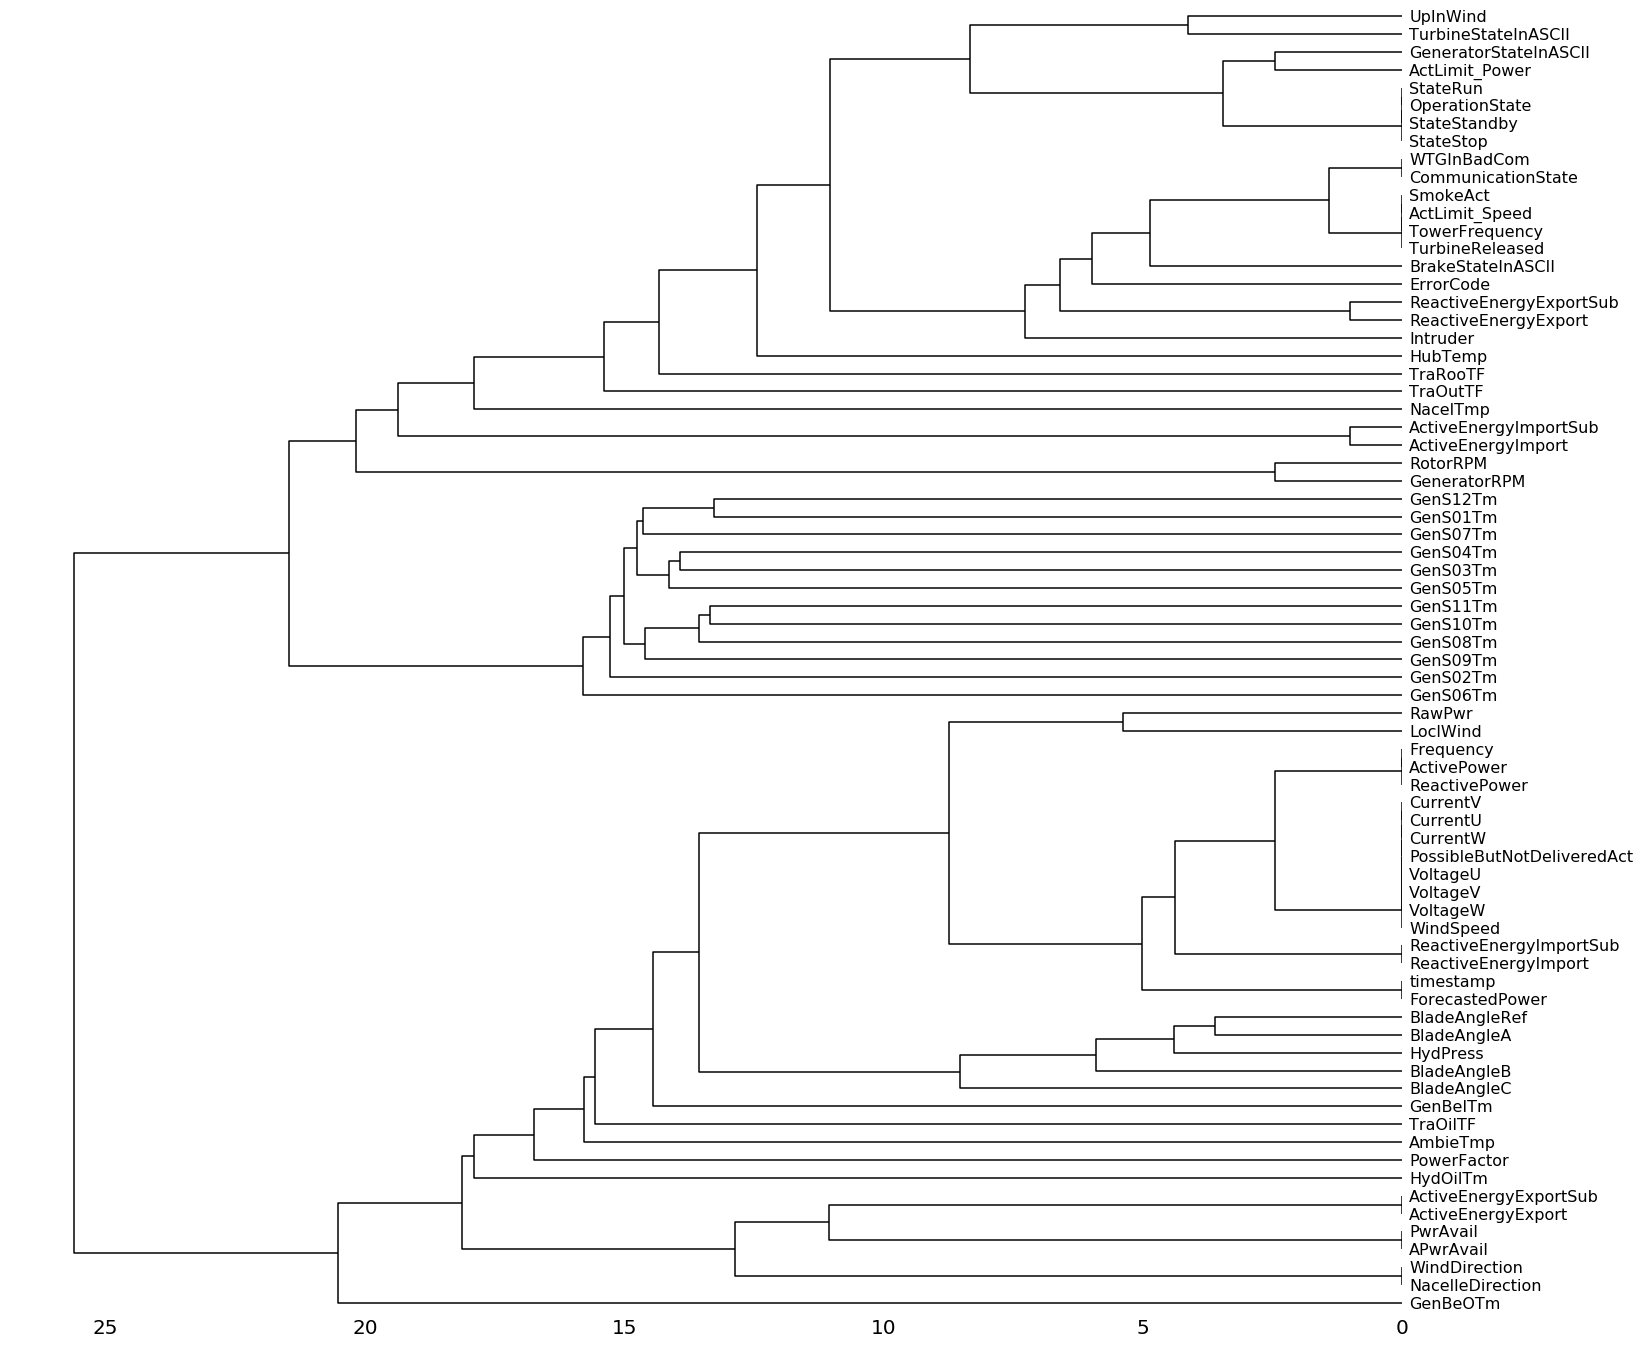

In [0]:
msno.dendrogram(turbines["T01"])

A function for creating the nullity correlation matrix for a given turbine

In [0]:
from utils import nullity_filter, nullity_sort
import numpy as np
def create_corr_matrix(turbine):
  
  turbines[turbine] = nullity_filter(turbines[turbine], filter=None, n=0, p=0)
  turbines[turbine] = nullity_sort(turbines[turbine], sort=None, axis='rows')

  # Remove completely filled or completely empty variables.
  turbines[turbine] = turbines[turbine].iloc[:,[i for i, n in enumerate(np.var(turbines[turbine].isnull(), axis='rows')) if n > 0]]

  # Create and mask the correlation matrix. Construct the base heatmap.
  corr_mat = turbines[turbine].isnull().corr()
  return corr_mat

After creating the nullity correlation matrix for a given turbine, we look at the nullity correlation between the different attributes for the turbine. We have decided to set the limit to -0.5, because that is pretty significant, and will give a good indicator on the missing data in one attribute given another attribute.

In [0]:
patternCounter = {} # total occurences of that tuple

def findCorr(limit, corr):
  corr_indexes = [x for x in corr.values.flatten()]
  corr_indexes = [i if x <= limit else -1 for i,x in enumerate(corr_indexes)]
  return corr_indexes

def getColumnNames(index, columns):
  x_index = int(index%len(columns))
  y_index = int(index/len(columns))
  return columns[x_index], columns[y_index]

for turbine in turbines:
  corr_mat = create_corr_matrix(turbine)
  corr_indexes = findCorr(-0.5, corr_mat)
  for i in corr_indexes:
    if i != -1:
      s = getColumnNames(i, corr_mat.columns)
      if s not in patternCounter:
        patternCounter[s] = 1
      else:
        patternCounter[s] += 1
patternCounter = {k: v for k, v in sorted(patternCounter.items(), key=lambda item: item[1], reverse=True)}
patterns = list(patternCounter.keys())
print(patternCounter)

{('ActiveEnergyImport', 'ActiveEnergyExport'): 34, ('ActiveEnergyImportSub', 'ActiveEnergyExport'): 34, ('ActiveEnergyImport', 'ActiveEnergyExportSub'): 34, ('ActiveEnergyImportSub', 'ActiveEnergyExportSub'): 34, ('ActiveEnergyExport', 'ActiveEnergyImport'): 34, ('ActiveEnergyExportSub', 'ActiveEnergyImport'): 34, ('ActiveEnergyExport', 'ActiveEnergyImportSub'): 34, ('ActiveEnergyExportSub', 'ActiveEnergyImportSub'): 34, ('ActiveEnergyImport', 'APwrAvail'): 26, ('ActiveEnergyImportSub', 'APwrAvail'): 26, ('APwrAvail', 'ActiveEnergyImport'): 26, ('PwrAvail', 'ActiveEnergyImport'): 26, ('APwrAvail', 'ActiveEnergyImportSub'): 26, ('PwrAvail', 'ActiveEnergyImportSub'): 26, ('ActiveEnergyImport', 'PwrAvail'): 26, ('ActiveEnergyImportSub', 'PwrAvail'): 26, ('BladeAngleRef', 'ActiveEnergyImport'): 8, ('BladeAngleRef', 'ActiveEnergyImportSub'): 8, ('ActiveEnergyImport', 'BladeAngleRef'): 8, ('ActiveEnergyImportSub', 'BladeAngleRef'): 8, ('HydPress', 'ActiveEnergyImport'): 7, ('ActiveEnergyImpo

In [0]:
turbines = {}
for key in data.keys():
  turbine = key.split('-')[0]
  if turbine in turbines:
    continue

  turbines[turbine] = pd.DataFrame()

  columns = sorted([col.split('-')[1] for col in filter(lambda s: key[:3] in s, data.columns)])
  for col in columns:
    turbines[turbine][col] = data[f'{turbine}-{col}']
  turbines[key[:3]]["timestamp"] = turbines[key[:3]].index

In [0]:
import plotly.graph_objects as go

fig = go.Figure()
t = turbines["T01"]
s = patterns[8]
for atr in s:
  fig.add_trace(go.Scatter(x=t["timestamp"], y=t[atr], name=atr))
fig.show()

Above, we see a pattern for the subcomponent for the "imported active energy" and "active power availability". We can see when there are missing data points for "active power availability", there is data for "imported active energy", and vice versa. We have discovered one of many patterns regarding missing data in the dataset.

In [0]:
corr_table = pd.DataFrame()

columns = {}
for key in patternCounter.keys():
  columns[key[0]] = True
  columns[key[1]] = True

corr_table["cols"] = columns.keys()
corr_table.set_index("cols")

for k in columns.keys():
  counts = []
  for j in columns.keys():
    counts.append(patternCounter[(k, j)] if (k, j) in patternCounter else 0)
  corr_table[k] = counts

In [0]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z=corr_table,
                   x=corr_table.columns,
                   y=corr_table.columns,
                   hoverongaps = False))
fig.show()

Above we can see the intensity of nullity correlation between the attributes for all the turbines in the dataset. To the right, you can see the intensity of the correlation (which is negative). The heatmap shows us that ActiveEnergyImport and ActiveEnergyExport have high nullity correlation, due to the fact that the turbine does not import and export data at the same time. We also see that ActiveEnergyExport/ActiveEnergyExportSub and APwrAvail have high nullity correlation, because the turbine does not export power when it does not have any available power to export.

# Conclusion